# Machine Learning Model Implementations
This file includes machine learning model implementations and optimization steps.
The models used in order is as follows:
1. KNN classifier
2. ...


### Import Packages and Load Dataset

Labels come from 2 different PSG systems: Remlogic and Somnomedics. Sleep stage labels are as follows:

0 = Awake = SLEEP-S0 \
1 = REM   = SLEEP-REM \
2 = Light = SLEEP-S1 and  SLEEP-S2 \
3 = Deep  = SLEEP-S3 

EMFIT is the piezoelectric mat and Somnofy is the radar.

In [4]:
!pip3 install tslearn

     |████████████████████████████████| 452 kB 4.5 MB/s eta 0:00:01


In [2]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from tslearn.metrics import dtw
from sklearn.tree import DecisionTreeClassifier

import numpy as np
from loader import *
from helpers import *
from sklearn.model_selection import train_test_split

In [8]:
print("Radar: ", balanced_accuracy_score( labels[:divide_ind], sleep_stages["sleep_stage_num_somnofy"][:divide_ind]))
print("Mat: ", balanced_accuracy_score( labels[:divide_ind], sleep_stages["sleep_stage_num_emfit"][:divide_ind]))

Radar:  0.45474044012102816
Mat:  0.5013282629573407


In [3]:
x, y, _, _ = get_nn_patients()
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.30, random_state=42)
x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((35, 857, 2), (16, 857, 2), (35, 857), (16, 857))

### Grid Search

In [4]:
x_tr_radar, x_tr_emfit = x_tr[:,:,0].T, x_tr[:,:,1].T
x_te_radar, x_te_emfit = x_te[:,:,0].T, x_te[:,:,1].T
y_tr_gd, y_te_gd = y_tr.T, y_te.T
x_tr_radar.shape, x_tr_emfit.shape, x_te_radar.shape, x_te_emfit.shape, y_tr_gd.shape, y_te_gd.shape

((857, 35), (857, 35), (857, 16), (857, 16), (857, 35), (857, 16))

In [25]:
def grid_search(radar, mat, psg, step=0.002, grid_limit=0.6):
    loss=100
    w_opt=np.zeros((2,1), dtype=float)
    w = np.zeros((2,1), dtype=float)
    while w[0] <= grid_limit:
        w[1]=0
        while w[1] <= grid_limit:
            e=np.zeros((radar.shape[0],radar.shape[1]))
            for i in range(radar.shape[1]):
                e[:,i]=(psg[:,i].reshape(radar.shape[0],1)-np.c_[mat[:,i],radar[:,i]].reshape(radar.shape[0],2)@w).reshape(radar.shape[0],)
            mse=np.zeros((radar.shape[1],1))
            for i in range(radar.shape[1]):
                mse[i]=1/2/radar.shape[0]*e[:,i].T@e[:,i]
            average_mse=np.mean(mse)
            if average_mse<loss:
                loss=average_mse
                w_opt[0], w_opt[1] = w[0], w[1]
            w[1]+=step
        w[0]+=step
    return w_opt

In [ ]:
w = grid_search(x_tr_radar, x_tr_emfit, y_tr_gd, step=0.002, grid_limit=.8)
#preds = get_predictions(w, x_te_emfit, x_te_radar) for each patient

In [ ]:
# Accuracy score 
print(balanced_accuracy_score(y_te_gd, preds))

# Confusion Matrix and Classification Report 
plot_conf_matrix(preds, y_te_gd, normalize = True)

### Gradient Descent

#### Method 1:

In [6]:
size = x_tr_radar.shape[0]
psg = np.zeros((size,1))
for i in range(size):
    psg[i]=round(np.mean(y_tr_gd[i,:]))
emfit_mean=np.zeros((size,1))
for i in range(size):
    emfit_mean[i]=np.mean(x_tr_emfit[i,:])
somnofy_mean=np.zeros((size,1))
for i in range(size):
    somnofy_mean[i]=np.mean(x_tr_radar[i,:])

w_m1, loss_m1= mse_gd(emfit_mean+1,somnofy_mean+1,psg+1, max_iters=1500, gamma=0.005,w0=True)

In [ ]:
preds = get_predictions(w_m1, x_te_emfit, x_te_radar)
# Accuracy score 
print(balanced_accuracy_score(y_te_gd, preds))

# Confusion Matrix and Classification Report 
plot_conf_matrix(preds, y_te_gd, normalize = True)

#### Method 2:


In [8]:
psg_freq = np.zeros((size,1))
for i in range(size):
    counts = np.bincount(y_tr_gd[i,:].astype(int))
    psg_freq[i]=np.argmax(counts)    

w_m2,loss_m2=mse_gd(emfit_mean+1,somnofy_mean+1,psg_freq+1, max_iters=1500, gamma=0.005,w0=True)

In [ ]:
preds = get_predictions(w_m2, x_te_emfit, x_te_radar)
# Accuracy score 
print(balanced_accuracy_score(y_te_gd, preds))

# Confusion Matrix and Classification Report 
plot_conf_matrix(preds, y_te_gd, normalize = True)

### Data preparation for the rest

In [25]:
train_size, test_size = x_tr.shape[0] * x_tr.shape[1], x_te.shape[0] * x_te.shape[1]
x_tr, x_te, y_tr, y_te = x_tr.reshape(train_size,2), x_te.reshape(test_size,2), y_tr.ravel(), y_te.ravel()

### KNN Classifier

In [20]:
knn_classifier = KNeighborsClassifier(n_neighbors=10, metric=dtw, n_jobs=-1)
knn_classifier.fit(x_tr, y_tr)

KNeighborsClassifier(metric=<function dtw at 0x7f9a51d11940>, n_jobs=-1,
                     n_neighbors=10)

In [21]:
preds = knn_classifier.predict(x_te)

0.2679169324876502
[[0.20824582 0.00108907 0.02543757 0.        ]
 [0.07763516 0.00715675 0.06830027 0.        ]
 [0.40614547 0.00427849 0.06565539 0.        ]
 [0.12640996 0.00054454 0.00910152 0.        ]]


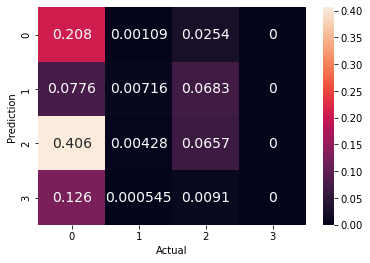

In [22]:
# Accuracy score 
print(balanced_accuracy_score(y_te, preds))

# Confusion Matrix and Classification Report 
plot_conf_matrix(preds, y_te, normalize = True)

0.49095835445074865
[[0.15449242 0.         0.08292493 0.00684559]
 [0.02473746 0.01143524 0.09404901 0.00186698]
 [0.04799689 0.         0.3478802  0.03383897]
 [0.01625827 0.00178919 0.09148191 0.08440296]]


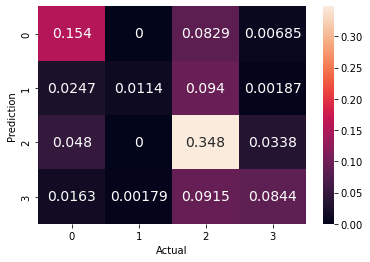

In [26]:
knn_classifier = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
knn_classifier.fit(x_tr, y_tr)
preds = knn_classifier.predict(x_te)
# Accuracy score 
print(balanced_accuracy_score( y_te, preds))

# Confusion Matrix and Classification Report 
plot_conf_matrix(preds, y_te, normalize = True)
# print(classification_report( y_te, preds))

### Naive Bayes 

In [27]:
cnb_classifier = CategoricalNB()
cnb_classifier.fit(x_tr, y_tr)

CategoricalNB()

In [28]:
preds = cnb_classifier.predict(x_te)

0.5897570157335947
[[0.14570206 0.02162583 0.07211202 0.00482303]
 [0.02497083 0.08518086 0.02030338 0.00163361]
 [0.04846363 0.0512641  0.30221704 0.0277713 ]
 [0.01275768 0.00676779 0.09404901 0.08035784]]


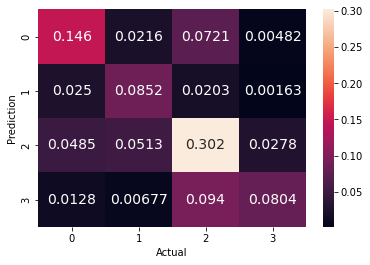

In [29]:
# Accuracy score 
print(balanced_accuracy_score( y_te, preds))

# Confusion Matrix and Classification Report 
plot_conf_matrix(preds, y_te, normalize = True)
# print(classification_report( y_te, preds))

### Decision Tree

In [32]:
classifier_feature = DecisionTreeClassifier()
classifier_feature.fit(x_tr, y_tr) 
preds = classifier_feature.predict(x_te)

In [34]:
print(classification_report(y_te,preds))
print(balanced_accuracy_score(y_te,preds))
print(accuracy_score(y_te,preds))

              precision    recall  f1-score   support

         0.0       0.63      0.63      0.63      3140
         1.0       0.51      0.64      0.57      1698
         2.0       0.64      0.70      0.67      5524
         3.0       0.70      0.41      0.52      2493

    accuracy                           0.62     12855
   macro avg       0.62      0.60      0.60     12855
weighted avg       0.63      0.62      0.62     12855

0.5990253733808272
0.6227148969272657


### Overall Balanced accuracy


In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    overall_balanced_accuracy()

Radar:   Acc =  0.5890376474187747 St. Dv. =  0.1805266427884278
Mat:   Acc =  0.37047027665760657 St. Dv. =  0.10266745272149581
kNN:   Acc =  0.42412158601351024 St. Dv. =  0.14730997269717408
NB:   Acc =  0.4772134774112359 St. Dv. =  0.1600312903460696
